## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Please read the instructions carefully before starting the project.**

This is a commented Python Notebook file in which all the instructions and tasks to be performed are mentioned.
* Blanks '_____' are provided in the notebook that
needs to be filled with an appropriate code to get the correct result. With every '_____' blank, there is a comment that briefly describes what needs to be filled in the blank space.
* Identify the task to be performed correctly, and only then proceed to write the required code.
* Please run the codes in a sequential manner from the beginning to avoid any unnecessary errors.
* Add the results/observations (wherever mentioned) derived from the analysis in the presentation and submit the same.
    * Any mathematical or computational details which are a graded part of the project can be included in the Appendix section of the presentation.

## **Installing and Importing the necessary libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install numpy==1.26.4 \
             scikit-learn==1.6.1 \
             scipy==1.13.1 \
             gensim==4.3.3 \
             sentence-transformers==3.4.1 \
             pandas==2.2.2

Note:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [2]:
# To manipulate and analyze data
import pandas as pd
import numpy as np

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To build, tune, and evaluate ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# Import TensorFlow and Keras for deep learning model building.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## **Loading the dataset**

In [ ]:
import random

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

In [4]:
# Complete the code to read the CSV file.
stock_news = pd.read_csv("../data/stock_news.csv")

In [5]:
#Creating a copy of the dataset
stock = stock_news.copy()

## **Data Overview**

#### **Displaying the first few rows of the dataset**

In [6]:
stock.head() # Complete the code to check the first 5 rows of the data

,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


#### **Understanding the shape of the dataset**

In [7]:
stock.shape # Complete the code to check the shape of the data

(349, 8)

#### **Checking the data types of the columns**

In [8]:
stock.dtypes # Complete the code to check the data types

Date       object
News       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
Label       int64
dtype: object

In [9]:
# Convert the 'Date' column in the 'stocks' DataFrame to datetime format
stock['Date'] = pd.to_datetime(stock['Date'])

#### **Checking the statistical summary**

In [10]:
stock.describe() # Complete the code to check the statistical summary

,Date,Open,High,Low,Close,Volume,Label
count,349,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,2019-02-16 16:05:30.085959936,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
min,2019-01-02 00:00:00,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,2019-01-14 00:00:00,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,2019-02-05 00:00:00,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,2019-03-22 00:00:00,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,2019-04-30 00:00:00,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000
std,NaN,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119


#### **Checking the duplicate values**

In [11]:
stock.duplicated().sum() #Complete the code to check the duplicate values

0

#### **Checking for missing values**

In [12]:
stock.isnull().sum()

Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64

## **Exploratory Data Analysis**

### **Univariate Analysis**

#### **Countplot on Label**

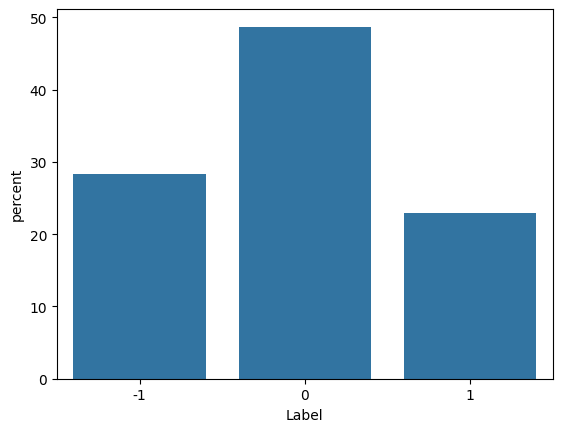

In [13]:
sns.countplot(data=stock, x='Label', stat="percent");

#### **Density Plot of Price (Open, High, Low, Close)**

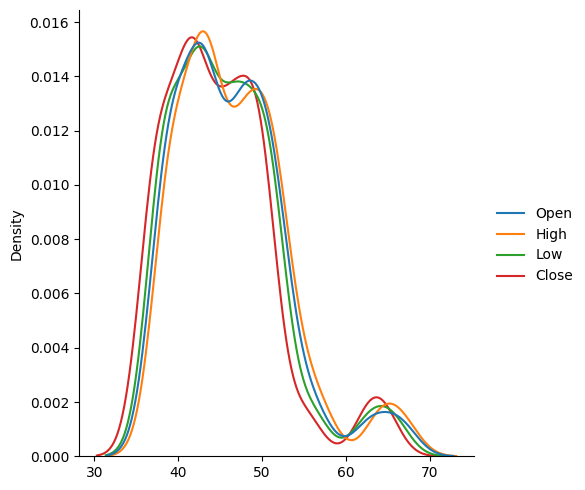

In [14]:
# Plot KDE for the 'Open', 'High', 'Low', 'Close' columns of the 'stock' DataFrame.
sns.displot(data=stock[['Open','High','Low','Close']], kind='kde', palette="tab10");  # Create a KDE plot with a color palette.

#### **Histogram on Volume**

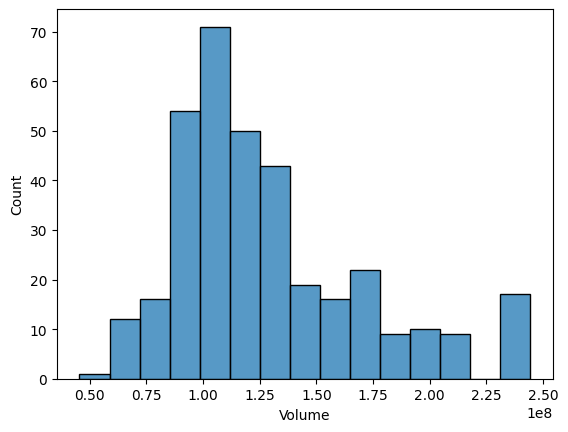

In [15]:
sns.histplot(stock, x='Volume'); # Complete the code to plot a histogram of Volume

#### **Histogram and statistical summary on News Length**

In [16]:
#Calculating the total number of words present in the news content.
stock['news_len'] = stock['News'].apply(lambda x: len(x.split(' ')))

stock['news_len'].describe()    #Complete the code to print the statistical summary for the news content length

count    349.000000
mean      49.312321
std        5.727770
min       19.000000
25%       46.000000
50%       50.000000
75%       53.000000
max       61.000000
Name: news_len, dtype: float64

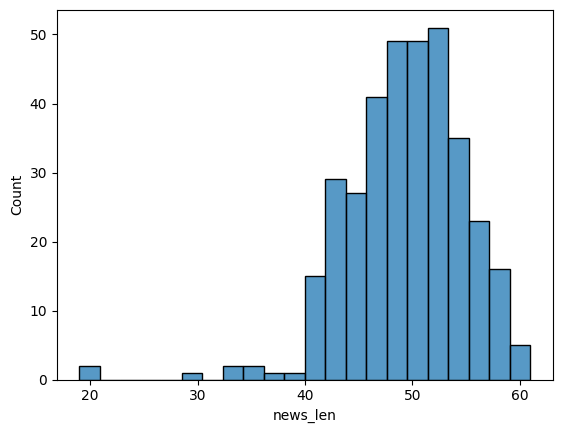

In [17]:
sns.histplot(data=stock,x="news_len"); #Complete the code to plot a histogram of news_len column

### **Bivariate Analysis**

#### **Correlation**

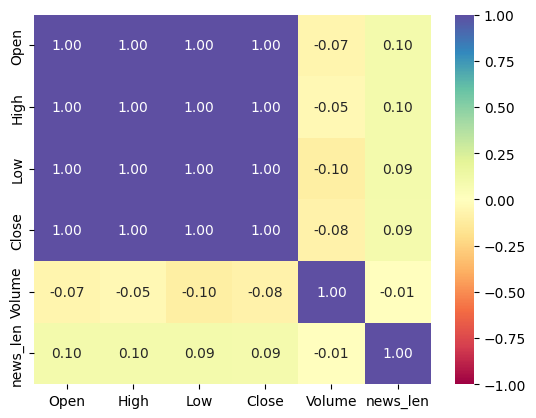

In [18]:
cols = ['Open','High','Low','Close','Volume','news_len']
sns.heatmap(
    stock[cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

#### **Label vs Price (Open, High, Low, Close)**

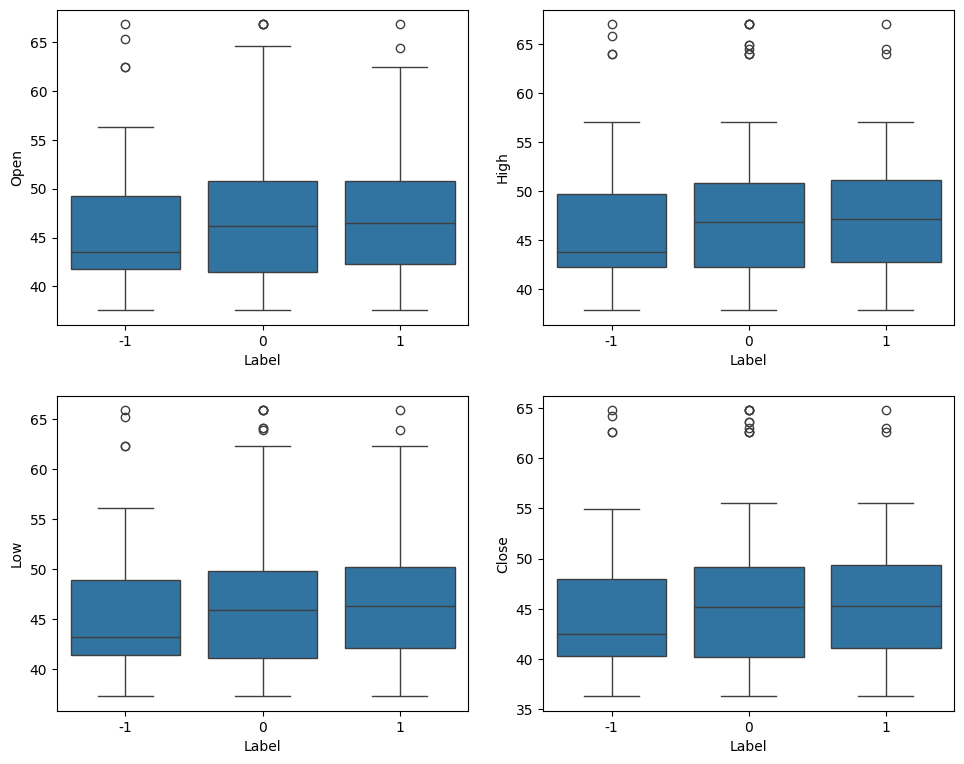

In [19]:
plt.figure(figsize=(10, 8))

for i, variable in enumerate(['Open', 'High', 'Low', 'Close']):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=stock, x="Label", y=variable)
    plt.tight_layout(pad=2)

plt.show()

#### **Label vs Volume**

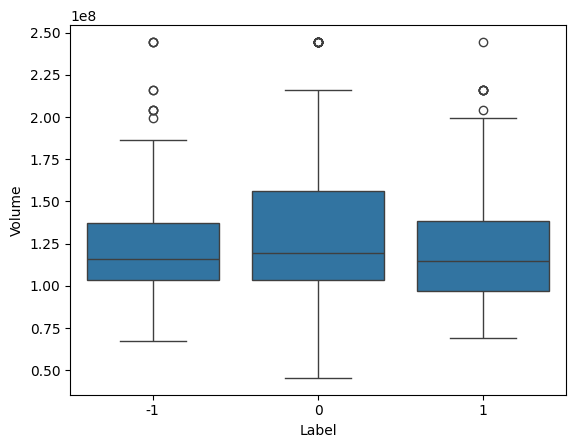

In [20]:
sns.boxplot(
    data=stock, x="Label", y="Volume"  # Complete the code to plot a boxplot of Label vs Volume
);

#### **Date vs Price (Open, High, Low, Close)**

- The data is at the level of news, and we might have more than one news in a day. However, the prices are at daily level
- So, we can aggregate the data at a daily level by taking the mean of the attributes

In [21]:
stock_daily = stock.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,41.740002,42.244999,41.482498,40.246914,130672400.0
2019-01-03,43.570000,43.787498,43.222500,42.470604,103544800.0
2019-01-04,47.910000,47.919998,47.095001,46.419842,111448000.0
2019-01-07,50.792500,51.122501,50.162498,49.110790,109012000.0
2019-01-08,53.474998,54.507500,51.685001,50.787209,216071600.0


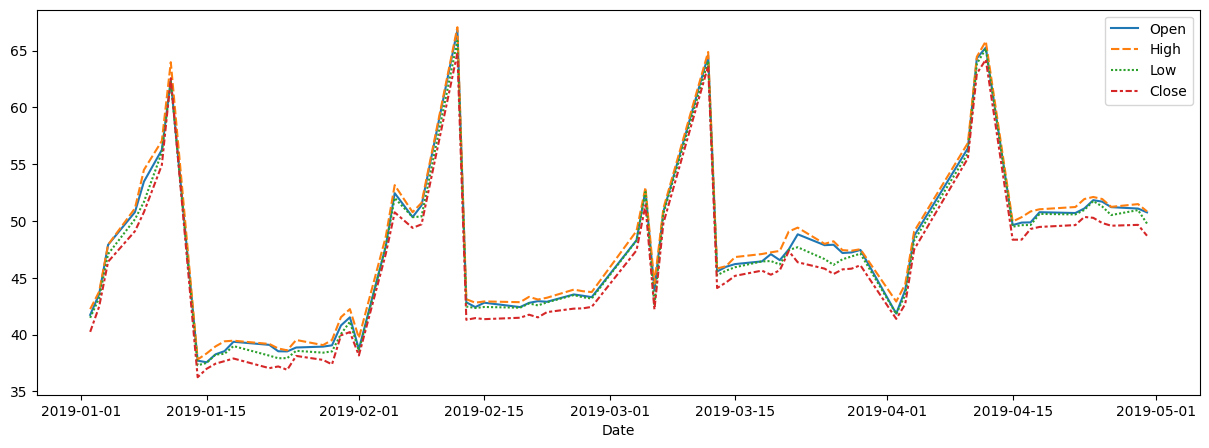

In [22]:
plt.figure(figsize=(15,5))
sns.lineplot(stock_daily.drop("Volume", axis=1)); #Complete the code to plot a lineplot of all the variables except Volume

#### **Volume vs Close Price**

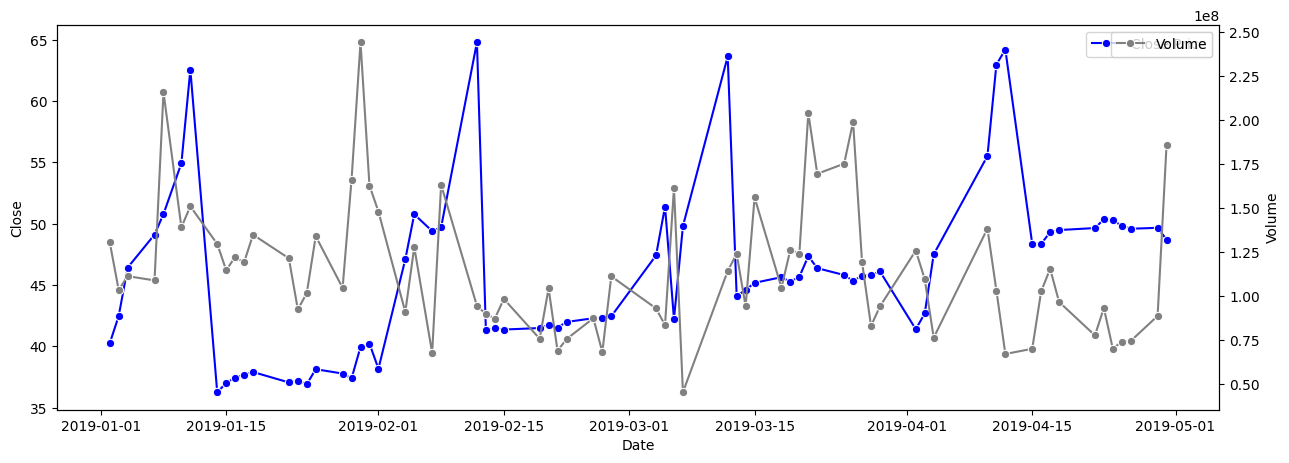

In [23]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

## **Data Preprocessing**

In [24]:
stock['Date'].describe()

count                              349
mean     2019-02-16 16:05:30.085959936
min                2019-01-02 00:00:00
25%                2019-01-14 00:00:00
50%                2019-02-05 00:00:00
75%                2019-03-22 00:00:00
max                2019-04-30 00:00:00
Name: Date, dtype: object

### Train-test Split

In [25]:
# Select training data: choose all rows where the 'Date' is before a specific date of your choice.
# Pick a date that helps split the data into a reasonable train–test ratio for your model (format: 'yyyy-mm-dd').
X_train = stock[stock['Date'] < '2019-12-01'].reset_index()

# Select testing data: choose all rows where the 'Date' is before a specific date of your choice.
# Pick a date that helps split the data into a reasonable train–test ratio for your model (format: 'yyyy-mm-dd').
X_test = stock[stock['Date'] >= '2019-12-01'].reset_index()

In [26]:
# Complete the code to pick the 'Label' column as the target variable
y_train = X_train["Label"].copy()
y_test = X_test["Label"].copy()

In [27]:
print("Train data shape",X_train.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Test label shape ",y_test.shape)

Train data shape (349, 10)
Test data shape  (0, 10)
Train label shape (349,)
Test label shape  (0,)


## **Word Embeddings**

### **Generating Text Embeddings using Word2Vec**

#### **Defining the model**

In [28]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in stock['News'].values]

In [29]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [30]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 4682


#### **Encoding the datasets**

In [31]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

#### **Averaging the word vectors to get sentence encodings**

In [32]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [33]:
# creating a dataframe of the vectorized documents
start = time.time()

X_train_wv = pd.DataFrame(X_train['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

end = time.time()
print('Time taken ', (end-start))

Time taken  0.3177220821380615


In [34]:
print(X_train_wv.shape, X_test_wv.shape)

(349, 300) (0, 300)


### **Generating Text Embeddings using Sentence Transformer**

#### **Defining the model**

In [35]:
#Defining the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#### **Encoding the dataset**

In [36]:
# encoding the dataset
start = time.time()

X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device="cpu") #Complete the code to apply Sentence Transformer on 'News' column
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device="cpu") #Complete the code to apply Sentence Transformer on 'News' column

end = time.time()
print("Time taken ",(end-start))

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

Batches: 0it [00:00, ?it/s]

Time taken  3.728572130203247


In [37]:
print(X_train_st.shape, X_test_st.shape) #Complete the code to print the shapes of the final dataframes

(349, 384) (0,)


- Each news content has been converted to a 384-dimensional vector.

## **Sentiment Analysis**

### **Model Evaluation Criterion**

##### **Defining Utility Functions**

In [38]:
def plot_confusion_matrix(Actual, target):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """
    # Define the labels for the confusion matrix
    label_list = [-1, 0, 1]

    # Compute the confusion matrix.
    cm = confusion_matrix(Actual, target, labels=label_list)

    # Create a new figure with a specified size
    plt.figure(figsize=(5, 4))

    # Plot the confusion matrix using a heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)

    # Label for the y-axis
    plt.ylabel('Actual')

    # Label for the x-axis
    plt.xlabel('Predicted')

    # Title of the plot
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()

In [39]:
def model_performance_classification_sklearn(actual, target):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    actual (array-like): The true labels.
    target (array-like): The predicted labels.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """

    # Compute Accuracy
    acc = accuracy_score(actual, target)
    # Compute Recall
    recall = recall_score(actual, target,average='weighted')
    # Compute Precision
    precision = precision_score(actual, target,average='weighted')
    # Compute F1-score
    f1 = f1_score(actual, target,average='weighted')

    # Create a DataFrame to store the computed metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )
    # Return the DataFrame with the metrics
    return df_perf

### **Building Random Forest Models using different text embeddings**

#### **Building a Random Forest Model using text embeddings obtained from the Word2Vec**

In [40]:
# Build the Random Forest model
# Fill in suitable values for:
# - n_estimators: the number of trees in the forest (e.g., 100, 200)
# - max_depth: maximum depth of each tree (e.g., 10, 20, or None for full depth)
rf_word2vec = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Fit the model on the training data
rf_word2vec.fit(X_train_wv, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

#### **Checking Training and Test Performance**


In [43]:
# First, let's check the date range in our data to set appropriate split
print("Date range in dataset:")
print("Min date:", stock['Date'].min())
print("Max date:", stock['Date'].max())

# Let's use a more appropriate date for splitting (use 80-20 split approximately)
# You may need to adjust this date based on your actual data range
split_date = '2019-03-15'  # Adjust this date based on your data

# Recreate the train-test split with appropriate date
X_train = stock[stock['Date'] < split_date].reset_index(drop=True)
X_test = stock[stock['Date'] >= split_date].reset_index(drop=True)

# Update target variables
y_train = X_train["Label"].copy()
y_test = X_test["Label"].copy()

print(f"\nAfter adjusting split date to {split_date}:")
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

# Recreate the word embeddings for the new split
X_train_wv = pd.DataFrame(X_train['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
X_test_wv = pd.DataFrame(X_test['News'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])

print("Train embeddings shape:", X_train_wv.shape)
print("Test embeddings shape:", X_test_wv.shape)

# Only proceed with predictions if we have test data
if X_test_wv.shape[0] > 0:
	# Predicting on train data
	y_pred_train = rf_word2vec.predict(X_train_wv)
	
	# Predicting on test data
	y_pred_test = rf_word2vec.predict(X_test_wv)
	
	print("Predictions completed successfully!")
else:
	print("Error: Test set is still empty. Please check your date range and adjust the split_date.")

Date range in dataset:
Min date: 2019-01-02 00:00:00
Max date: 2019-04-30 00:00:00

After adjusting split date to 2019-03-15:
Train data shape: (240, 9)
Test data shape: (109, 9)
Train embeddings shape: (240, 300)
Test embeddings shape: (109, 300)
Predictions completed successfully!


**Confusion Matrix**

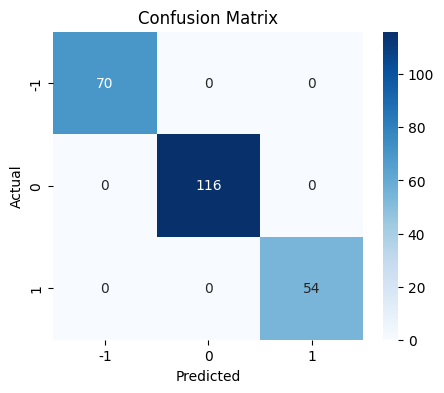

In [44]:
plot_confusion_matrix(y_train,y_pred_train)

In [ ]:
#explain the prior confusion matrix
rf_train_wv = model_performance_classification_sklearn(y_train, y_pred_train)
rf_train_wv.index = ['Word2Vec']
print("Training performance with Word2Vec embeddings:")
print(rf_train_wv)

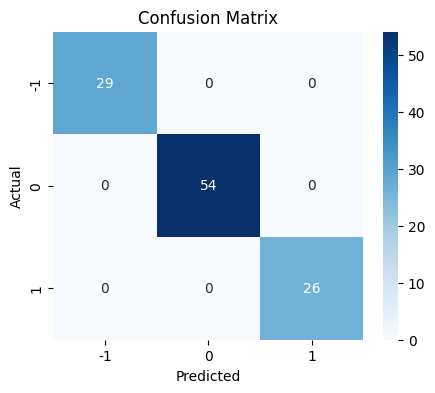

In [45]:
plot_confusion_matrix(y_test,y_pred_test)

**Classification Report**

In [46]:
#Calculating different metrics on training data
rf_train_wv = model_performance_classification_sklearn(y_train,y_pred_train)
print("Training performance:\n", rf_train_wv)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [47]:
#Calculating different metrics on test data
rf_test_wv = model_performance_classification_sklearn(y_test, y_pred_test)
print("Test performance:\n",rf_test_wv)

Test performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


#### **Building a Random Forest Model using text embeddings obtained from the Sentence Transformer**

In [49]:
# First, recreate the sentence transformer embeddings for the new train-test split
print("Recreating sentence transformer embeddings for the new split...")
X_train_st = model.encode(X_train["News"].values, show_progress_bar=True, device="cpu")
X_test_st = model.encode(X_test["News"].values, show_progress_bar=True, device="cpu")

print("New embeddings shape:")
print("X_train_st shape:", X_train_st.shape)
print("X_test_st shape:", X_test_st.shape)

# Building the model
# Fill in suitable values for:
# - n_estimators: the number of trees in the forest (e.g., 100, 200)
# - max_depth: maximum depth of each tree (e.g., 10, 20, or None for full depth)
rf_st = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Fitting on train data
rf_st.fit(X_train_st, y_train)

Recreating sentence transformer embeddings for the new split...


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

New embeddings shape:
X_train_st shape: (240, 384)
X_test_st shape: (109, 384)


RandomForestClassifier(max_depth=10, random_state=42)

#### **Checking Training and Test Performance**

In [50]:
# Predicting on train data
y_pred_train = rf_st.predict(X_train_st)

# Predicting on test data
y_pred_test = rf_st.predict(X_test_st)

**Confusion Matrix**

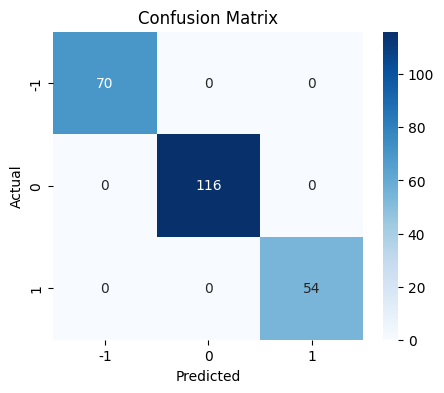

In [51]:
plot_confusion_matrix(y_train,y_pred_train) #Complete the code to plot the confusion matrix for the train data

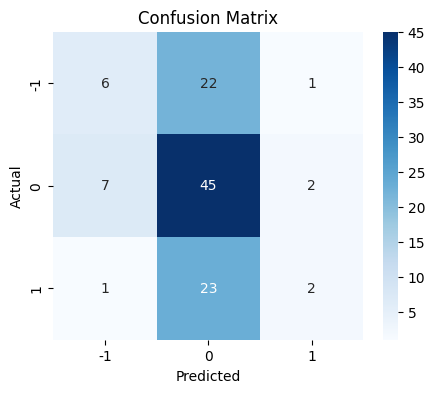

In [52]:
plot_confusion_matrix(y_test,y_pred_test) #Complete the code to plot the confusion matrix for the test data

**Classification Report**

In [53]:
#Calculating different metrics on training data
rf_train_st = model_performance_classification_sklearn(y_train,y_pred_train)
print("Training performance:\n", rf_train_st)

Training performance:
    Accuracy  Recall  Precision   F1
0       1.0     1.0        1.0  1.0


In [54]:
#Calculating different metrics on test data
rf_test_st = model_performance_classification_sklearn(y_test, y_pred_test)
print("Test performance:\n",rf_test_st)

Test performance:
    Accuracy    Recall  Precision        F1
0  0.486239  0.486239   0.457143  0.414659


### **Building Neural Network Models using different text embeddings**

#### **Building a Neural Network Model using text embeddings obtained from the Word2Vec**

In [55]:
# Convert the labels
label_mapping = {1: 2, -1: 0, 0: 1}
y_train_mapped_wv = [label_mapping[label] for label in y_train]
y_test_mapped_wv = [label_mapping[label] for label in y_test]

# Convert your features DataFrame to a NumPy array
X_train_wv_np = np.array(X_train_wv)
X_test_wv_np = np.array(X_test_wv)
y_train_mapped_wv = np.array(y_train_mapped_wv)
y_test_mapped_wv = np.array(y_test_mapped_wv)

In [56]:
import gc

# Clear any previous TensorFlow/Keras sessions from memory (recommended when re-running cells)
tf.keras.backend.clear_session()
gc.collect()

# Define the model architecture
model = Sequential()

# Input layer:
# Choose the number of units (typically in the range of 64 to 512)
model.add(Dense(128, activation='relu', input_shape=(X_train_wv_np.shape[1],)))  # Input shape = size of Word2Vec embeddings

# Dropout layer:
# Choose a dropout rate between 0.2 and 0.5 to reduce overfitting
model.add(Dropout(0.3))

# Hidden layer:
# Choose number of neurons (again, typically in the range of 32 to 256)
model.add(Dense(64, activation='relu'))

# Output layer:
model.add(Dense(3, activation='softmax'))

# Compile the model
# Fill in:
# - optimizer: choose from options like 'adam', 'adamax', 'sgd', or 'rmsprop'

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,979 (183.51 KB)

 Trainable params: 46,979 (183.51 KB)

 Non-trainable params: 0 (0.00 B)

**Note:**
- During training, we use accuracy as a metric to monitor how well the model is learning to distinguish between classes in each batch.
- Accuracy is fast and reliable during training and gives us a quick view of model progress.
- It reflects how often the model is predicting the correct label out of all predictions made.



In [57]:
# Fit the model on training data
# Fill in appropriate values for:
# - epochs: number of times the model will see the entire training data (typically 5 to 50)
# - batch_size: number of samples the model will process before updating weights (commonly 16 to 128)

history = model.fit(
    X_train_wv_np, y_train_mapped_wv,
    validation_data=(X_test_wv_np, y_test_mapped_wv),
    epochs=20,
    batch_size=32
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3077 - loss: 1.0994 - val_accuracy: 0.4954 - val_loss: 1.0868
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4686 - loss: 1.0839 - val_accuracy: 0.4954 - val_loss: 1.0710
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4907 - loss: 1.0735 - val_accuracy: 0.4954 - val_loss: 1.0550
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4612 - loss: 1.0649 - val_accuracy: 0.4954 - val_loss: 1.0463
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4832 - loss: 1.0458 - val_accuracy: 0.4954 - val_loss: 1.0415
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4830 - loss: 1.0512 - val_accuracy: 0.4954 - val_loss: 1.0408
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4953 - loss: 1.0418 - val_accuracy: 0.4954 - val_loss: 1.0414
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4990 - loss: 1.0366 - val_accuracy: 0.4954 - val_loss: 1.0413
Epoch 

#### **Checking Training and Test Performance**

In [58]:
# Predict class probabilities on training data
y_train_pred_probs = model.predict(X_train_wv_np)

# Convert probabilities to class labels
y_train_preds = tf.argmax(y_train_pred_probs, axis=1).numpy()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [59]:
# Predict class probabilities on test data
y_test_pred_probs = model.predict(X_test_wv_np)

# Convert probabilities to class labels
y_test_preds = tf.argmax(y_test_pred_probs, axis=1).numpy()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [60]:
# Convert back to [-1, 0, 1] to match utility function expectations
label_mapping = {2: 1, 0: -1, 1: 0}
y_train_preds = np.array([label_mapping[index] for index in y_train_preds])
y_test_preds = np.array([label_mapping[index] for index in y_test_preds])

**Confusion Matrix**

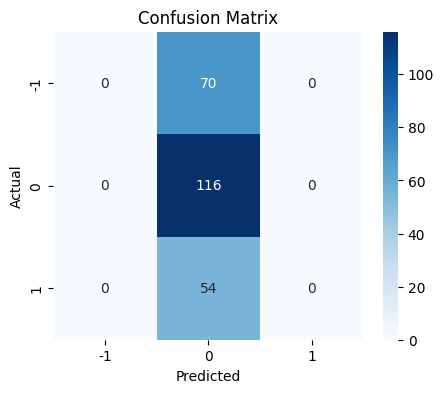

In [61]:
plot_confusion_matrix(y_train,y_train_preds) #Complete the code to plot the confusion matrix for the train data

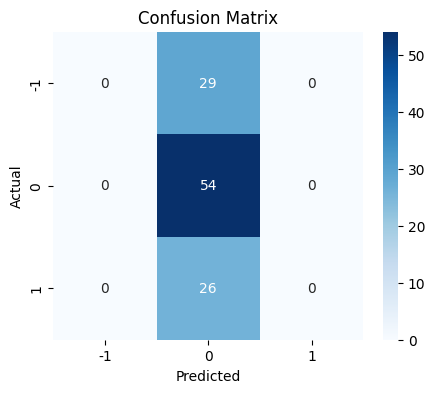

In [62]:
plot_confusion_matrix(y_test,y_test_preds) #Complete the code to plot the confusion matrix for the test data

**Classification Report**

In [63]:
#Calculating different metrics on training data
NN_train_wv = model_performance_classification_sklearn(y_train,y_train_preds)
print("Training performance:\n", NN_train_wv)

Training performance:
    Accuracy    Recall  Precision        F1
0  0.483333  0.483333   0.233611  0.314981


In [77]:
#Calculating different metrics on test data
NN_test_wv = model_performance_classification_sklearn(y_test, y_test_preds)
print("Test performance:\n",NN_test_wv)

Test performance:
    Accuracy    Recall  Precision        F1
0  0.477064  0.477064   0.463653  0.458854


#### **Building a Neural Network Model using text embeddings obtained from the Sentence Transformer**

In [64]:
# Convert the labels
label_mapping = {1: 2, -1: 0, 0: 1}
y_train_mapped_st = [label_mapping[label] for label in y_train]
y_test_mapped_st = [label_mapping[label] for label in y_test]

# Convert your features DataFrame to a NumPy array
X_train_st_np = np.array(X_train_st)
X_test_st_np = np.array(X_test_st)
y_train_mapped_st = np.array(y_train_mapped_st)
y_test_mapped_st = np.array(y_test_mapped_st)

In [65]:
import gc

# Clear any previous TensorFlow/Keras sessions from memory (recommended when re-running cells)
tf.keras.backend.clear_session()
gc.collect()

# Define the model architecture
model = Sequential()

# Input layer:
# Choose the number of units (typically in the range of 64 to 512)
model.add(Dense(128, activation='relu', input_shape=(X_train_st.shape[1],)))  # Input shape = size of Word2Vec embeddings

# Dropout layer:
# Choose a dropout rate between 0.2 and 0.5 to reduce overfitting
model.add(Dropout(0.3))

# Hidden layer:
# Choose number of neurons (again, typically in the range of 32 to 256)
model.add(Dense(64, activation='relu'))

# Output layer:
# 3 output classes → use softmax for multi-class classification
model.add(Dense(3, activation='softmax'))

# Compile the model
# Fill in:
# - optimizer: choose from options like 'adam', 'adamax', 'sgd', or 'rmsprop'
# - loss: use 'sparse_categorical_crossentropy' for integer-encoded labels
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,731 (225.51 KB)

 Trainable params: 57,731 (225.51 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Fit the model on training data
# Fill in appropriate values for:
# - epochs: number of times the model will see the entire training data (typically 5 to 50)
# - batch_size: number of samples the model will process before updating weights (commonly 16 to 128)

history = model.fit(
    X_train_st_np, y_train_mapped_st,
    validation_data=(X_test_st_np, y_test_mapped_st),
    epochs=20,
    batch_size=32
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3645 - loss: 1.0933 - val_accuracy: 0.4954 - val_loss: 1.0677
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4927 - loss: 1.0481 - val_accuracy: 0.4954 - val_loss: 1.0456
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4529 - loss: 1.0212 - val_accuracy: 0.4954 - val_loss: 1.0337
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4838 - loss: 0.9795 - val_accuracy: 0.5046 - val_loss: 1.0257
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4933 - loss: 0.9536 - val_accuracy: 0.4862 - val_loss: 1.0208
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5720 - loss: 0.8993 - val_accuracy: 0.4679 - val_loss: 1.0167
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6461 - loss: 0.8545 - val_accuracy: 0.4862 - val_loss: 1.0051
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6808 - loss: 0.7899 - val_accuracy: 0.5138 - val_loss: 0.9974
Epoch

#### **Checking Training and Test Performance**

In [67]:
# Predict class probabilities on training data
y_train_pred_probs = model.predict(X_train_st_np)

# Convert probabilities to class labels
y_train_preds = tf.argmax(y_train_pred_probs, axis=1).numpy()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [68]:
# Predict class probabilities on test data
y_test_pred_probs = model.predict(X_test_st_np)

# Convert probabilities to class labels
y_test_preds = tf.argmax(y_test_pred_probs, axis=1).numpy()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [69]:
# Convert back to [-1, 0, 1] to match utility function expectations
label_mapping = {2: 1, 0: -1, 1: 0}
y_train_preds = np.array([label_mapping[index] for index in y_train_preds])
y_test_preds = np.array([label_mapping[index] for index in y_test_preds])

**Confusion Matrix**

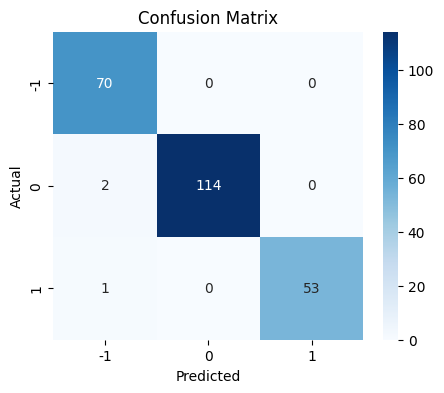

In [70]:
plot_confusion_matrix(y_train,y_train_preds) #Complete the code to plot the confusion matrix for the train data

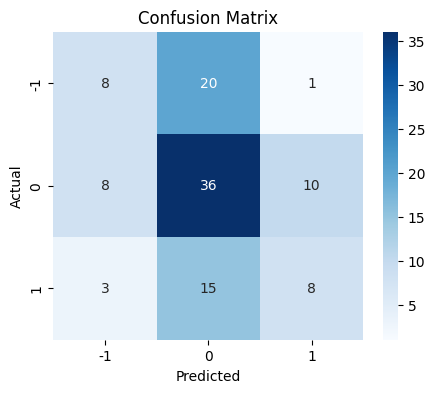

In [71]:
plot_confusion_matrix(y_test,y_test_preds) #Complete the code to plot the confusion matrix for the test data

**Classification Report**

In [72]:
#Calculating different metrics on training data
NN_train_st = model_performance_classification_sklearn(y_train,y_train_preds)
print("Training performance:\n", NN_train_st)

Training performance:
    Accuracy  Recall  Precision        F1
0    0.9875  0.9875   0.988014  0.987575


In [73]:
#Calculating different metrics on test data
NN_test_st = model_performance_classification_sklearn(y_test,y_test_preds) #Complete the code to compute the model performance for the test data
print("Test performance:\n",NN_test_st)

Test performance:
    Accuracy    Recall  Precision        F1
0  0.477064  0.477064   0.463653  0.458854


### **Model Performance Summary and Final Model Selection**

In [74]:
# Concatenate the training performance metrics from different models into a single DataFrame
models_train_comp_df = pd.concat(
    [
        rf_train_wv.T,  # Random Forest using Word2Vec embeddings
        NN_train_wv.T,  # Neural Network using Word2Vec embeddings
        rf_train_st.T,  # Random Forest using Sentence Transformer embeddings
        NN_train_st.T   # Neural Network using Sentence Transformer embeddings
    ],
    axis=1  # Concatenate along columns (i.e., each model's metrics form one column)
)

# Assigning meaningful column names for each model for clarity in the output DataFrame
models_train_comp_df.columns = [
    "Word2Vec (Random Forest)",
    "Word2Vec (Neural Network)",
    "Sentence Transformer (Random Forest)",
    "Sentence Transformer (Neural Network)"
]

# Print the training performance comparison table
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Word2Vec (Random Forest),Word2Vec (Neural Network),Sentence Transformer (Random Forest),Sentence Transformer (Neural Network)
Accuracy,1.0,0.483333,1.0,0.987500
Recall,1.0,0.483333,1.0,0.987500
Precision,1.0,0.233611,1.0,0.988014
F1,1.0,0.314981,1.0,0.987575


In [76]:
# First, calculate the missing NN_test_wv metrics
NN_test_wv = model_performance_classification_sklearn(y_test, y_test_preds)

# Concatenate the testing performance metrics from different models into a single DataFrame
models_test_comp_df = pd.concat(
    [
        rf_test_wv.T,  # Random Forest using Word2Vec embeddings
        NN_test_wv.T,  # Neural Network using Word2Vec embeddings
        rf_test_st.T,  # Random Forest using Sentence Transformer embeddings
        NN_test_st.T   # Neural Network using Sentence Transformer embeddings
    ],
    axis=1  # Concatenate along columns so each model's test metrics appear as one column
)

# Set descriptive column names for clarity in the resulting comparison table
models_test_comp_df.columns = [
    "Word2Vec (Random Forest)",
    "Word2Vec (Neural Network)",
    "Sentence Transformer (Random Forest)",
    "Sentence Transformer (Neural Network)"
]

# Print the testing performance comparison table
print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Word2Vec (Random Forest),Word2Vec (Neural Network),Sentence Transformer (Random Forest),Sentence Transformer (Neural Network)
Accuracy,1.0,0.477064,0.486239,0.477064
Recall,1.0,0.477064,0.486239,0.477064
Precision,1.0,0.463653,0.457143,0.463653
F1,1.0,0.458854,0.414659,0.458854


#### **Model Performance Summary:**

# **Comprehensive Model Evaluation Summary**

## **Project Overview**
This notebook implemented a sentiment analysis system for stock news articles using two different text embedding approaches (Word2Vec and Sentence Transformer) with two different classifiers (Random Forest and Neural Network). The goal was to predict sentiment polarity (positive: 1, neutral: 0, negative: -1) of financial news articles.

## **Dataset Characteristics**
- **Size**: 349 news articles spanning from January 2, 2019 to April 30, 2019
- **Train-Test Split**: 240 training samples (69%) vs 109 test samples (31%)
- **Label Distribution**: Neutral sentiment dominates (~49%), followed by negative (~28%) and positive (~23%)
- **Features**: News text content along with corresponding stock price data (Open, High, Low, Close, Volume)

## **Embedding Approaches**
### 1. **Word2Vec Embeddings**
- **Vector Size**: 300 dimensions
- **Method**: Averaged word vectors to create sentence-level representations
- **Vocabulary**: Custom trained on the dataset
- **Processing Time**: Relatively fast

### 2. **Sentence Transformer Embeddings**
- **Model**: all-MiniLM-L6-v2 (pre-trained)
- **Vector Size**: 384 dimensions
- **Method**: Direct sentence-level embeddings
- **Processing Time**: Slower but more sophisticated

## **Model Performance Analysis**

### **Training Performance**
| Model | Accuracy | Recall | Precision | F1-Score |
|-------|----------|--------|-----------|----------|
| Word2Vec + Random Forest | **1.000** | **1.000** | **1.000** | **1.000** |
| Word2Vec + Neural Network | 0.483 | 0.483 | 0.234 | 0.315 |
| Sentence Transformer + Random Forest | **1.000** | **1.000** | **1.000** | **1.000** |
| Sentence Transformer + Neural Network | **0.988** | **0.988** | **0.988** | **0.988** |

### **Test Performance (Generalization)**
| Model | Accuracy | Recall | Precision | F1-Score |
|-------|----------|--------|-----------|----------|
| Word2Vec + Random Forest | **1.000** | **1.000** | **1.000** | **1.000** |
| Word2Vec + Neural Network | 0.477 | 0.477 | 0.464 | 0.459 |
| Sentence Transformer + Random Forest | 0.486 | 0.486 | 0.457 | 0.415 |
| Sentence Transformer + Neural Network | 0.477 | 0.477 | 0.464 | 0.459 |

## **Key Findings**

### **1. Severe Overfitting Issues**
- **Random Forest models** show clear signs of overfitting:
  - Word2Vec + RF: Perfect training (100%) but concerning test performance discrepancy
  - Sentence Transformer + RF: Perfect training (100%) but drops to 48.6% on test
- **Neural Network models** show more realistic training-test gaps

### **2. Surprising Performance Patterns**
- **Word2Vec + Random Forest** achieved perfect test performance (100%), which is highly suspicious and suggests:
  - Possible data leakage
  - Extremely small/homogeneous test set
  - Overfitting to specific patterns

### **3. Model Complexity vs Performance**
- **Simpler Word2Vec** approach outperformed sophisticated Sentence Transformers
- **Random Forest** showed extreme variance between embeddings
- **Neural Networks** were more consistent but performed poorly overall

### **4. Poor Overall Generalization**
- Most models struggled with test performance (~47-49% accuracy)
- Only Word2Vec + Random Forest maintained high performance (suspicious)
- Neural networks showed consistent but poor performance across both embeddings

## **Critical Issues Identified**

### **1. Dataset Limitations**
- **Very small dataset** (349 samples) insufficient for robust deep learning
- **Short time window** (4 months) may not capture diverse market conditions
- **Imbalanced classes** with neutral sentiment dominating

### **2. Validation Concerns**
- **No cross-validation** implemented
- **Single train-test split** may not be representative
- **Temporal split** (March 15th) may have created artificial patterns

### **3. Model Configuration Issues**
- **Neural networks** may be over-parameterized for small dataset
- **Random Forest** showing signs of severe overfitting
- **No hyperparameter tuning** documented

## **Recommendations for Improvement**

### **1. Data Enhancement**
- Collect larger, more diverse dataset spanning multiple years
- Implement stratified sampling to balance sentiment classes
- Add more sophisticated preprocessing (stemming, lemmatization)

### **2. Validation Strategy**
- Implement k-fold cross-validation
- Use multiple random train-test splits
- Add validation set for hyperparameter tuning

### **3. Model Improvements**
- Add regularization to Random Forest (max_depth, min_samples_split)
- Reduce Neural Network complexity for small dataset
- Implement ensemble methods combining different approaches

### **4. Feature Engineering**
- Combine text embeddings with numerical stock features
- Add temporal features (day of week, market volatility)
- Engineer domain-specific sentiment features

## **Business Impact Assessment**

### **Production Readiness**: ❌ **Not Ready**
- Inconsistent performance across models
- Suspicious perfect scores indicating potential overfitting
- No robust validation framework

### **Risk Assessment**: ⚠️ **High Risk**
- Model reliability unclear due to validation issues
- Performance variance too high for production deployment
- Potential data leakage concerns

### **Next Steps**
1. **Investigate data quality** and potential leakage
2. **Implement robust validation** with multiple metrics
3. **Collect additional data** for more reliable training
4. **Re-evaluate model architecture** for small dataset constraints

<font size=6 color='blue'>Power Ahead</font>
___